In [1]:
import os
import glob
import itertools
import multiprocessing

from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as st
from sklearn.neighbors import KernelDensity
import sunpy.coordinates.sun as sn

import huxt as H
import huxt_inputs as Hin
import huxt_analysis as HA
import sir_huxt_mono_obs as sir


mpl.rc("axes", labelsize=16)
mpl.rc("ytick", labelsize=16)
mpl.rc("xtick", labelsize=16)
mpl.rc("legend", fontsize=16)

C:\Users\yq904481\Anaconda\envs\sir_huxt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(2022390)
    
# Get CME parameters from HELCATS HCME_B__20110601_01
#############################################
# SET UP HUXt instances 
dt_scale=20
start_time = Time('2011-06-01T20:08:00')
cr_num = np.fix(sn.carrington_rotation_number(start_time))
ert = H.Observer('EARTH', start_time)

vr_in = Hin.get_MAS_long_profile(cr_num, ert.lat.to(u.deg))

# Set up HUXt for a 5 day simulation, outputting every dt_scale 
model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
               lon_start=290*u.deg, lon_stop=70*u.deg, simtime=5*u.day, dt_scale=dt_scale)

# And hi-res 1-d run for Earth arrival
model1d = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
               lon_out=0*u.deg, simtime=5*u.day, dt_scale=4)

##############################################
# SET UP Cone CME
t_launch = (1*u.hr).to(u.s)
base_cme = H.ConeCME(t_launch=t_launch, longitude=8*u.deg, latitude=-4*u.deg, width=47.6*u.deg, v=643*(u.km/u.s),
                thickness=1*u.solRad)


#######################################################
# Get HUXt solution of this truth CME, and observations
model.solve([base_cme])
cme_truth = model.cmes[0]

# Also do hi-res 1d run for arrival time at Earth
model1d.solve([base_cme])
cme_arr = model1d.cmes[0]
arrival_stats = cme_arr.compute_arrival_at_body('EARTH')
hit = arrival_stats['hit']
if arrival_stats['hit']:
    t_transit = arrival_stats['t_transit'].to(u.s).value
    v_hit = arrival_stats['v'].value
else:
    t_transit = np.NaN
    v_hit = np.NaN

observer_lon = -60
Obs = sir.Observer(model, cme_truth, observer_lon*u.deg, el_min=4.0, el_max=35.0)

# Make directory to store this experiment in
dirs = sir.get_project_dirs()
if observer_lon < 0:
    lon_out = observer_lon + 360
else:
    lon_out = observer_lon

output_dir = 'l5_case_study'
output_dir = os.path.join(dirs['sir_analysis'], output_dir)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Run the SIR scheme on this event many times to see how the performance is

# Make a guess at the CME initial values 
cme_guess = sir.perturb_cme(base_cme)

# Low observational error
observed_cme_flank = Obs.compute_synthetic_obs(el_spread=0.1, cadence=1, el_min=4.0, el_max=35.0)

observations = {'observer_lon':observer_lon*u.deg, 'observed_cme_flank':observed_cme_flank, 'truth_cme_params':cme_truth.parameter_array(), 't_transit':t_transit, 'v_hit':v_hit}

tag = "HCME_B__20110601_01"
n_ens = 100
sir.SIR(model, model1d, cme_guess, observations, n_ens, output_dir, tag)

Files already exist for CR2110


In [10]:
def summarise_analysis(sir_file):
    """
    Function to load and summarise the results from an SIR osse experiment. Takes a list of files returned by the osse, 
    and returns a dictionary summarising the ensemble and ensemble average of CME properties
    
    """
    # Get list of parameters to aggregate compute
    keys = ['v', 'v_avg', 'v_std', 'v_rank',
            'width', 'width_avg', 'width_std', 'width_rank',
            'lon', 'lon_avg', 'lon_std', 'lon_rank',
            't_transit', 't_transit_avg', 't_transit_std',
            'v_hit', 'v_hit_avg', 'v_hit_std', 'e_obs', 'weight']
    
    # Make dictionary to store aggregated ensemble data and computed statistics
    data = {'prior':{k:[] for k in keys}, 'post':{k:[] for k in keys},
            'truth':{'v':[], 'width':[], 'lon':[], 't_transit':[], 'v_hit':[]}}

    # Set a counter for files with no data for the prior or posterior steps
    bad_count = 0

    out_file = h5py.File(sir_file, 'r')    

    # First file only, pull out the truth data. This is
    # identical across files
    # Parse out the true CME values
    cme_truth_params = out_file['truth_cme_params'][:]        
    data['truth']['v'] = cme_truth_params[4]
    data['truth']['width'] = np.rad2deg(cme_truth_params[3])
    lon_truth = np.rad2deg(cme_truth_params[1])
    if lon_truth > 180:
        lon_truth -= 360
    data['truth']['lon'] = lon_truth
    data['truth']['t_transit'] = out_file['t_transit_truth'][()]/3600 # PARALEL REQUIRES _TRUTH
    data['truth']['v_hit'] = out_file['v_hit_truth'][()]

    # Now pull out the ensemble data for the prior and posterior
    for j, key in enumerate(['prior', 'post']):

        if key == 'prior':
            analysis_key = 'analysis_00'
        elif key == 'post':
            analysis_key = 'analysis_07'

        if analysis_key not in out_file.keys():
            bad_count += 1
            continue

        data[key]['e_obs'].append(out_file[analysis_key]['e_obs'][()])
        data[key]['weight'].append(out_file[analysis_key]['weight'][:])

        for param in ['v', 'width', 'lon', 't_transit', 'v_hit']:
            # Now pass out the ensemble data
            x = out_file[analysis_key][param][:]
            if param == 'lon':
                x[x>180] -= 360
                data[key]['n_ens'] = len(x)
                
            if param == 't_transit':
                x = x / (60*60)

            data[key][param].append(x)
            data[key][param + '_avg'].append(np.mean(x))
            data[key][param + '_std'].append(np.std(x))

            # Now compute rank of truth in each ensemble of CME core parameters
            if param in ['v', 'width', 'lon']:
                x_truth = data['truth'][param]
                x_all = np.append(x, x_truth)
                x_ranks = st.rankdata(x_all)
                data[key][param + '_rank'].append(x_ranks[-1])

    out_file.close()

    # Turn the lists to numpy arrays
    for key in ['prior', 'post']:
        for param, vals in data[key].items():
            data[key][param] = np.array(vals).ravel()
            
    data[key]['v_wavg'] = np.average(data[key]['v'], weights=data[key]['weight'])
    data[key]['lon_wavg'] = np.average(data[key]['lon'], weights=data[key]['weight'])
    data[key]['width_wavg'] = np.average(data[key]['width'], weights=data[key]['weight'])
    data[key]['t_transit_wavg'] = np.average(data[key]['t_transit'], weights=data[key]['weight'])
    
    return data

sir_file = "C:/Users/yq904481/research/repos/SIR_HUXt/data/sir_analysis/l5_case_study/SIR_HUXt_HCME_B__20110601_01.hdf5"
data = summarise_analysis(sir_file)


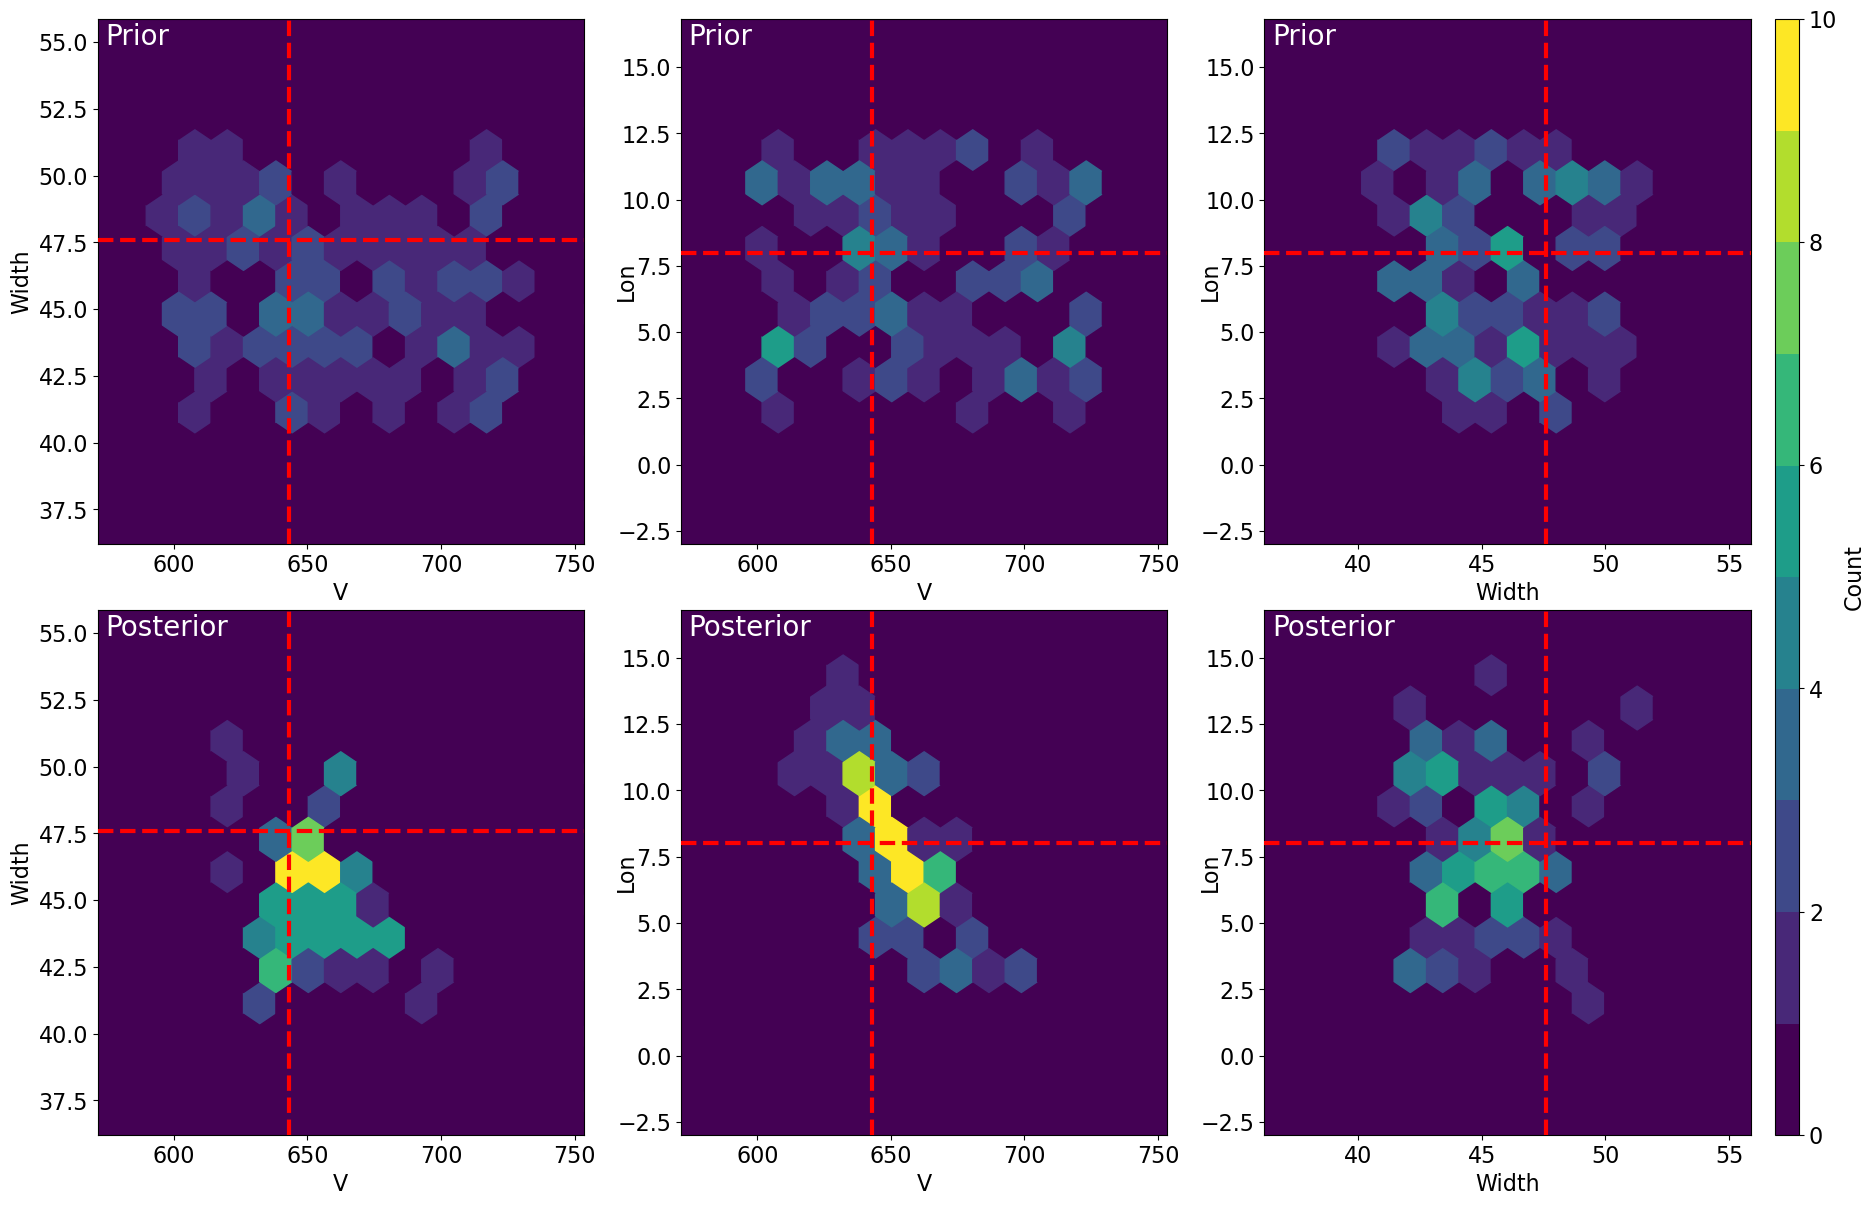

In [9]:
# Make hexbin plots of the particle densities
fig, ax = plt.subplots(2, 3, figsize=(19, 12))

vmin = data['prior']['v'].min() - 25
vmax = data['prior']['v'].max() + 25
wmin = data['prior']['width'].min() - 5
wmax = data['prior']['width'].max() + 5
lmin = data['prior']['lon'].min() - 5
lmax = data['prior']['lon'].max() + 5

vwlims = (vmin, vmax, wmin, wmax)
vllims = (vmin, vmax, lmin, lmax)
wllims = (wmin, wmax, lmin, lmax)

zmin = 0
zmax = 10
# define the bins and normalize
cmap = mpl.cm.get_cmap('viridis')
bounds = np.arange(zmin, zmax + 1, 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

for i, key in enumerate(['prior', 'post']):
    ax[i, 0].hexbin(data[key]['v'], data[key]['width'], gridsize=15, extent=vwlims, norm=norm, cmap=cmap)
    ax[i, 1].hexbin(data[key]['v'], data[key]['lon'], gridsize=15, extent=vllims, norm=norm, cmap=cmap)
    hb = ax[i, 2].hexbin(data[key]['width'], data[key]['lon'], gridsize=15, extent=wllims, norm=norm, cmap=cmap)


# Format the axes
for a in ax[:,0]:
    a.vlines(data['truth']['v'], vwlims[2], vwlims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
    a.hlines(data['truth']['width'], vwlims[0], vwlims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
    a.set_xlim(vwlims[0], vwlims[1])
    a.set_ylim(vwlims[2], vwlims[3]) 
    a.set_xlabel('V')
    a.set_ylabel('Width')

for a in ax[:, 1]:
    a.vlines(data['truth']['v'], vllims[2], vllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
    a.hlines(data['truth']['lon'], vllims[0], vllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
    a.set_xlim(vllims[0], vllims[1])
    a.set_ylim(vllims[2], vllims[3])
    a.set_xlabel('V')
    a.set_ylabel('Lon')
    a.yaxis.labelpad = -15

for a in ax[:, 2]:
    a.vlines(data['truth']['width'], wllims[2], wllims[3], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
    a.hlines(data['truth']['lon'], wllims[0], wllims[1], zorder=9, linestyle=['--'], colors=['r'], linewidth=3)
    a.set_xlim(wllims[0], wllims[1])
    a.set_ylim(wllims[2], wllims[3])
    a.set_xlabel('Width')
    a.set_ylabel('Lon')
    a.yaxis.labelpad = -15

labels = ['Prior', 'Posterior']
for i, lab in enumerate(labels):
    for j in range(ax.shape[1]):
        ax[i, j].text(0.015, 0.95, lab, fontsize=20, color='w', transform=ax[i, j].transAxes)

fig.subplots_adjust(left=0.06, bottom=0.06, right=0.93, top=0.99, wspace=0.2, hspace=0.125)

pos1 = ax[0, 2].get_position()
pos2 = ax[1, 2].get_position()
dw = 0.005
dh = 0.1
top = pos1.y1
bottom = pos2.y0
height = top - bottom
left = pos1.x1 + pos1.width/20
wid = pos1.width/20
cbaxes = fig.add_axes([left, bottom, wid, height])
cbar = fig.colorbar(hb, cax=cbaxes, orientation='vertical')
cbar.set_label('Count')

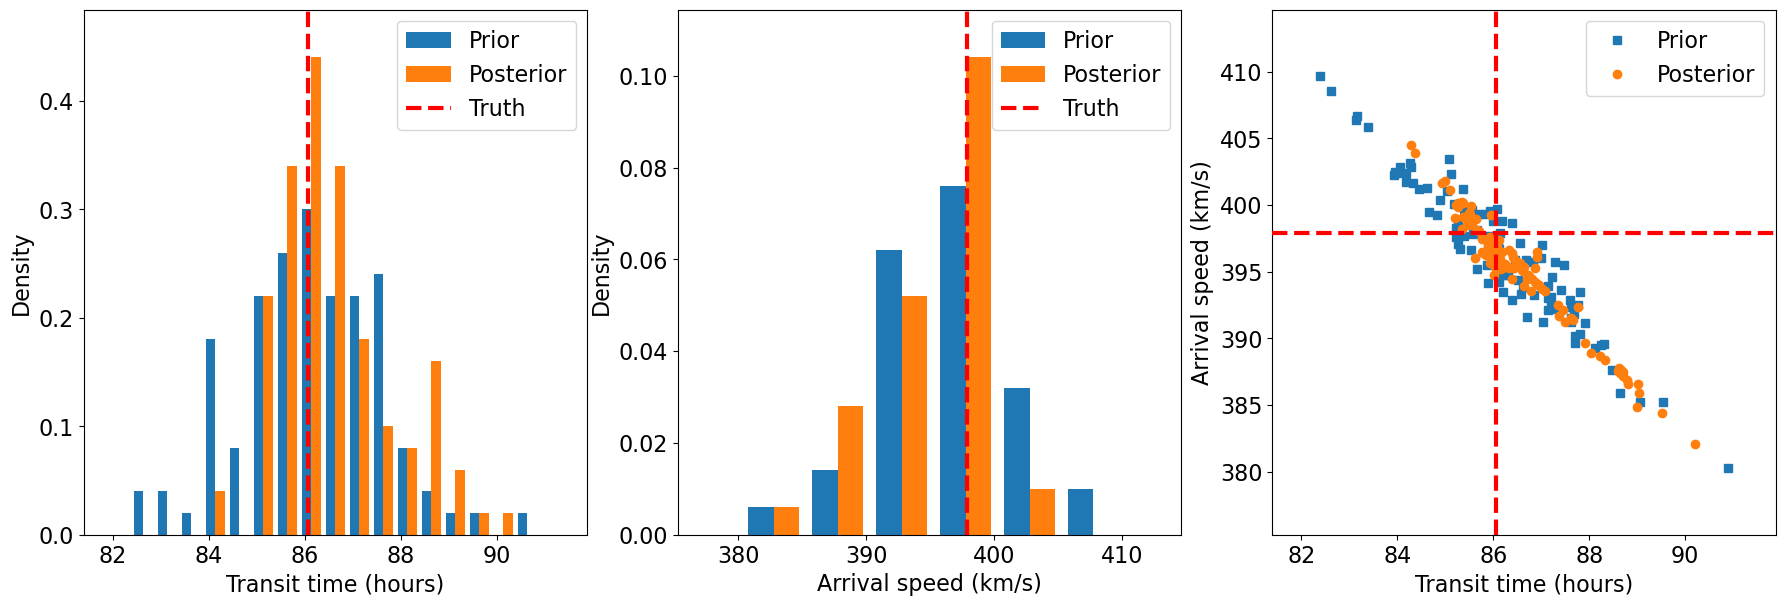

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Density estimates of arrival time
t_arr_hists = [data[key]['t_transit'] for key in ['prior', 'post']]
v_hit_hists = [data[key]['v_hit'] for key in ['prior', 'post']]

t_min = t_arr_hists[0].min() - 1
t_max = t_arr_hists[0].max() + 1

v_min = v_hit_hists[0].min() - 5
v_max = v_hit_hists[0].max() + 5

lims = (t_min, t_max, v_min, v_max)

labels = ['Prior', 'Posterior']
nt, bins, patch = ax[0].hist(t_arr_hists, np.arange(lims[0], lims[1], 0.5), density=True, label=labels)
nt_max = np.max([np.max(n) for n in nt])
nt_max = 1.1*nt_max
ax[0].vlines(data['truth']['t_transit'], 0, nt_max, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')

nv, bins, patch = ax[1].hist(v_hit_hists, np.arange(lims[2], lims[3], 5), density=True, label=labels)
nv_max = np.max([np.max(n) for n in nv])
nv_max = 1.1*nv_max
ax[1].vlines(data['truth']['v_hit'], 0, nv_max, zorder=9, linestyle=['--'], colors='r', linewidth=3, label='Truth')


ax[2].plot(t_arr_hists[0], v_hit_hists[0],'s', color="C0", label=labels[0])
ax[2].plot(t_arr_hists[1], v_hit_hists[1],'o', color="C1", label=labels[1])
ax[2].hlines(data['truth']['v_hit'], lims[0], lims[1], zorder=9, linestyle=['--'], colors='r', linewidth=3)
ax[2].vlines(data['truth']['t_transit'], lims[2], lims[3], zorder=9, linestyle=['--'], colors='r', linewidth=3)

ax[0].set_xlabel('Transit time (hours)')
ax[0].set_ylabel('Density')

ax[1].set_xlabel('Arrival speed (km/s)')
ax[1].set_ylabel('Density')

ax[2].set_xlabel('Transit time (hours)')
ax[2].set_ylabel('Arrival speed (km/s)')

ax[0].set_xlim(lims[0], lims[1])
ax[0].set_ylim(0, nt_max)

ax[1].set_xlim(lims[2], lims[3])
ax[1].set_ylim(0, nv_max)

ax[2].set_xlim(lims[0], lims[1])
ax[2].set_ylim(lims[2], lims[3])

for a in ax:
    a.legend()

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.975, wspace=0.18)


In [13]:
id_best = np.argmax(data['post']['weight'])

print(data['truth']['v'], data['truth']['lon'], data['truth']['width'], data['truth']['t_transit'])
print(data['post']['v'][id_best], data['post']['lon'][id_best], data['post']['width'][id_best], data['post']['t_transit'][id_best])
print(data['post']['v_wavg'], data['post']['lon_wavg'], data['post']['width_wavg'], data['post']['t_transit_wavg'])
print(data['post']['v_avg'], data['post']['lon_avg'], data['post']['width_avg'], data['post']['t_transit_avg'])
print(data['prior']['v_avg'], data['prior']['lon_avg'], data['prior']['width_avg'], data['prior']['t_transit_avg'])


643.0 8.0 47.6 86.06043400615454
625.3045813990245 13.162031348004945 51.0538707863708 86.90914456173778
648.0042006182263 8.087980316934198 45.01738819674003 86.86835052768397
[652.21163665] [7.81045309] [45.17096793] [86.58459104]
[661.34063575] [7.0626585] [45.6511604] [86.14828304]
